# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processing from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [1]:
import os
import pandas as pd
import rioxarray as rioxr # auto imports xarray
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [2]:
# Import NIR TIF file
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'rioxarray_lesson_data')

fp = os.path.join(root,
                 'NAIP_SB_nir.tif')

nir = rioxr.open_rasterio(fp)

In [3]:
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Directly access attributes of `nir`:

In [4]:
print('Shape: ', nir.shape)
print('Data type: ', nir.dtype)

Shape:  (1, 3208, 2419)
Data type:  uint8


`uint8` = one of the smallest number data types for Python = unsigned integer with 8 bits. It is used to represent numbers from 0 to 254. Powers of 2, every bit is a combo of 0 and 1 in 8 bits. 

We can access the underlying `numpy.array` holding the values of the variable:

In [5]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

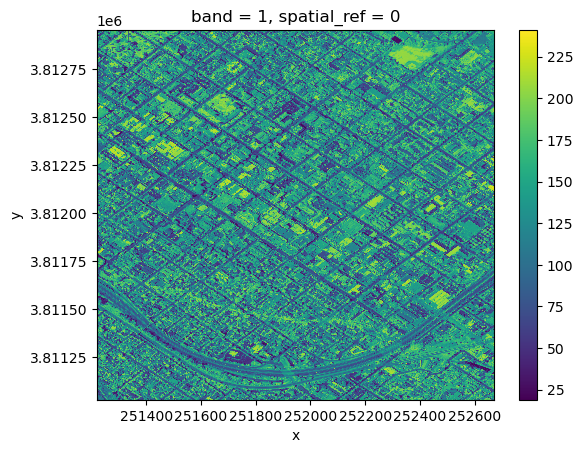

In [6]:
# Plot the raster
nir.plot()

## Drop dimension

Notice that our raster has an unnecessary extra dimension: band. 

In [9]:
print('Sizes of dimensions: ', dict(nir.sizes)) # dict() removes frozen, makes output prettier

Sizes of dimensions:  {'band': 1, 'y': 3208, 'x': 2419}


In [8]:
nir.sizes

Frozen({'band': 1, 'y': 3208, 'x': 2419})

Let's squeeze the band dim by:

1. `squeeze()` method, with no parameters, it gets rid of all dims length 1
2. drop the coordinates associated w the dimension using `drop_vars()` 

In [10]:
# Original dimensions and coordinates
print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [11]:
# Remove length 1 dim (band)
nir = nir.squeeze()
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [12]:
# Remove coords associated w band dim
nir = nir.drop_vars('band')
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


## `rio` accessor

accessor let's python think about that object in a different way. i.e., `str`, `datetime`

Use the `rio` accessor for an `xarray.DataArray` to access its raster properties, to access geospatial info

In [13]:
print('Number of bands: ', nir.rio.count)
print('Height: ', nir.rio.height)
print('Width: ', nir.rio.width)
print('Bbox: ', nir.rio.bounds(), '\n')

print('CRS', nir.rio.crs)



Number of bands:  1
Height:  3208
Width:  2419
Bbox:  (251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS EPSG:26911


## Multi band raster

import RGB raster

In [15]:
# Import rgb raster

fp = os.path.join(root, 'NAIP_SB_rgb.tif')

rgb= rioxr.open_rasterio(fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

since this raster has three bands we can plot it as an image using `.plot.imshow()` method, which will interpret the three bands as RGB bands.

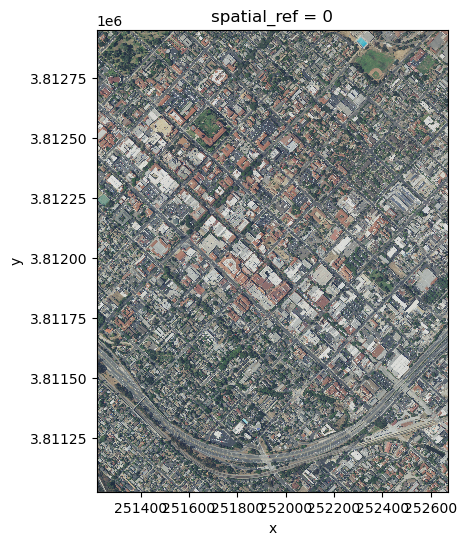

In [16]:
# Plot three bands as RGB image
rgb_aspect_ratio = rgb.rio.width / rgb.rio.height # Raster aspect ratio 
rgb.plot.imshow(size = 6, # plot's height in inches
               aspect = rgb_aspect_ratio) # Ratio in width/height

## Clip a raster

Our arae of interst AOI is a smaller region a few blocks from NCEAS. Already outlined in a GeoJSON file

<Axes: >

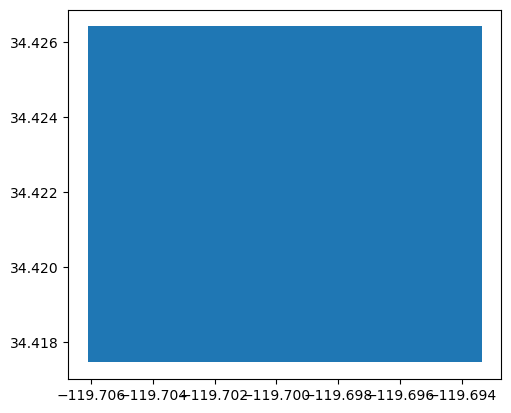

In [18]:
fp = os.path.join(root, 'SB_aoi.geojson')
aoi = gpd.read_file(fp)
aoi.plot()

In [23]:
# Examine CRSs
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

aoi CRS:  PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26911"]]
nir CRS:  EPSG:26911
rgb CRS:  EPSG:26911


In [24]:
# Reproject aoi to rgb CRS
aoi = aoi.to_crs(rgb.rio.crs)
assert aoi.crs == rgb.rio.crs

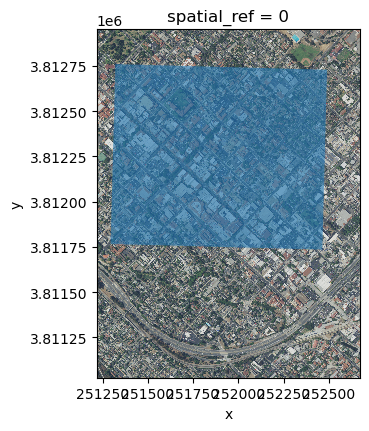

In [26]:
# Plot rgb raster with aoi overlay
fig, ax = plt.subplots(figsize =(6,6*rgb_aspect_ratio)) # Directly set size 
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)
plt.show()

To clip the raster we use the `rio.clip_biox()` method

In [29]:
aoi.total_bounds
# xmin, ymin, xmax, ymax

array([ 251294.31339082, 3811734.95697039,  252490.65041356,
       3812760.09703315])

In [32]:
# Clip raster to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)
# * unpacks what's in the object and passes it one by one to the function

In [34]:
# examine the clip data
print('Original shape: ', nir.shape)
print('Clipped shape: ', nir_small.shape)

Original shape:  (3208, 2419)
Clipped shape:  (1710, 1995)


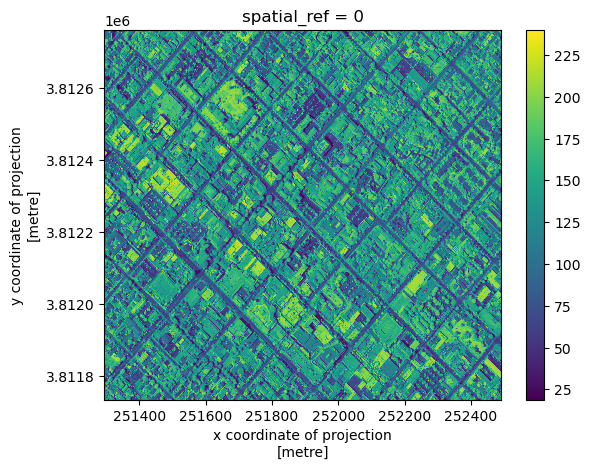

In [35]:
nir_small.plot()

Original shape:  (3, 3208, 2419)
Clipped shape:  (3, 1710, 1995)


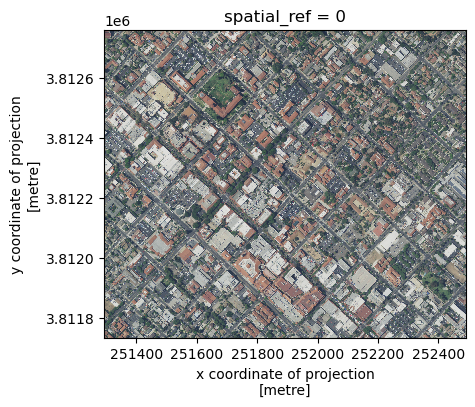

In [37]:
# Examine the clip data
print('Original shape: ', rgb.shape)
print('Clipped shape: ', rgb_small.shape)

# Plot w correct size
ratio = rgb_small.rio.width / rgb_small.rio.height # Raster aspect ratio

rgb_small.plot.imshow(size = 4,
               aspect = ratio)

## Raster algebra

In our case, we are interested in computing the Normalized Difference Vegetation Index (NDVI) 

NDVI is an index commnly used to check if an area has live green vegetation or not. 

- NDVI calcuation ranges from -1 to 1
- negative values = water, impervious surfaces, rocks, snow, clouds, etc. 
- bare soil = 0.1-0.2 range
- plants = always positive between 0.2-1

Formula for NDVI is

$NDVI = \frac{NIR - RED}{NIR + RED}$

In [38]:
rgb_small

<xarray.DataArray (band: 3, y: 1710, x: 1995)> Size: 10MB
[10234350 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [39]:
# Select the red band (by selecting dim by name and coord by label)
# We know first band is red from metadata
red = rgb_small.sel(band=1) 
red

<xarray.DataArray (y: 1710, x: 1995)> Size: 3MB
[3411450 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

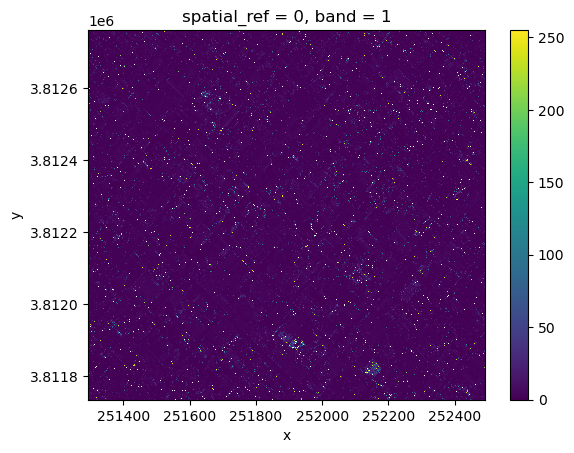

In [40]:
ndvi = (nir - red) / (nir + red)
ndvi.plot()

## Data type issues

The rasters had data type `uint8`, a very small data type holding only integers from 0-255
In particular, when you do calcuations with `uint8`, they don't return what you would expect when working with integers.

In [42]:
np.uint8(150) + np.uint8(150)

/tmp/ipykernel_2110747/1890984988.py:1: RuntimeWarning: overflow encountered in scalar add
  np.uint8(150) + np.uint8(150)


44

## Updating data types

To be able to perform calculations successfully, we need to update the data type of our rasters into `int16`

`u` in `uint8` means unsigned integer, won't hold negative numbers. `int16` will hold both neg and pos

In [46]:
# Update data type to int16 to perform NDVI calculation
# COMMENTS SHOULD ENHANCE, NOT BE REDUNDANT, explain why you're doing the thing
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

print(red16.dtype)
print(nir16.dtype)

int16
int16


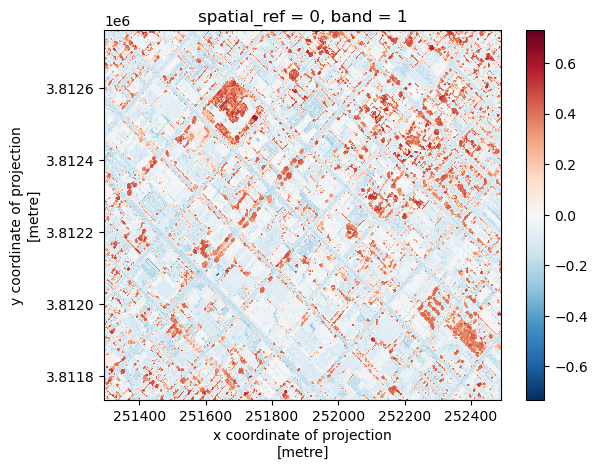

In [44]:
ndvi = (nir16 - red16) / (nir16 + red16)
ndvi.plot()